Imports


In [1]:
!pip install wandb thop torchvision matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from thop import profile
import wandb


In [3]:
wandb.login()
wandb.init(
    project="cifar10-cnn-lab",
    name="simple-cnn-cifar10"
)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ikamboj-919 (ikamboj-919-iit-jodhpur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms


In [7]:
class CIFAR10Custom(Dataset):
    def __init__(self, train=True, transform=None):
        self.dataset = datasets.CIFAR10(
            root="./data",
            train=train,
            download=True
        )
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])


In [9]:
train_dataset = CIFAR10Custom(
    train=True,
    transform=train_transform
)

test_dataset = CIFAR10Custom(
    train=False,
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))


100%|██████████| 170M/170M [00:18<00:00, 9.02MB/s]


Train batches: 391
Test batches: 79


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model


CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [12]:
dummy_input = torch.randn(1, 3, 32, 32).to(device)

macs, params = profile(
    model,
    inputs=(dummy_input,),
    verbose=False
)

print("FLOPs (MACs):", macs)
print("Total Parameters:", params)


FLOPs (MACs): 6654464.0
Total Parameters: 1070794.0


In [13]:
def plot_gradient_flow(named_parameters):
    ave_grads = []
    layers = []

    for name, param in named_parameters:
        if param.requires_grad and param.grad is not None:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean().cpu())

    plt.figure(figsize=(10, 5))
    plt.plot(ave_grads)
    plt.xticks(range(len(layers)), layers, rotation=90)
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient Flow")
    plt.grid(True)
    plt.show()


In [14]:
wandb.login()

wandb.init(
    project="cnn-cifar10-lab2",
    name="cnn-class-aligned"
)


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch [1/25]  Loss: 622.0790  Acc: 41.65%


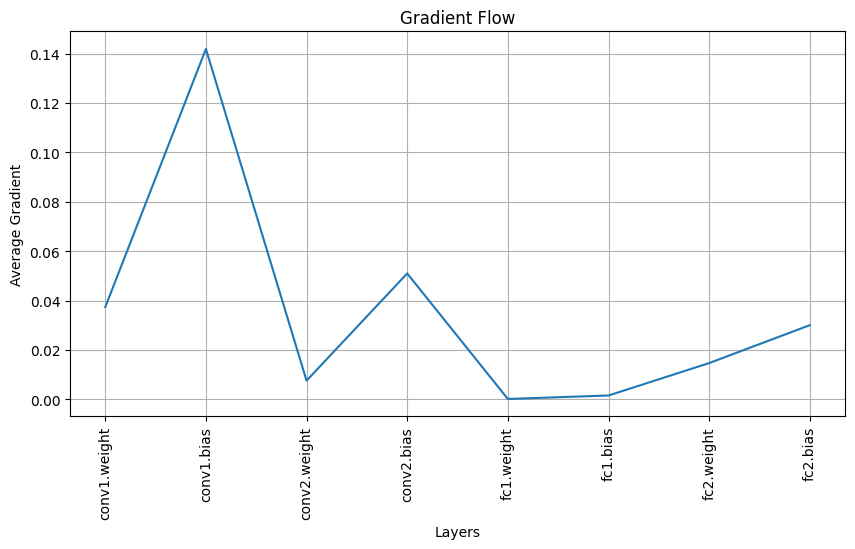

Epoch [2/25]  Loss: 490.7370  Acc: 55.15%


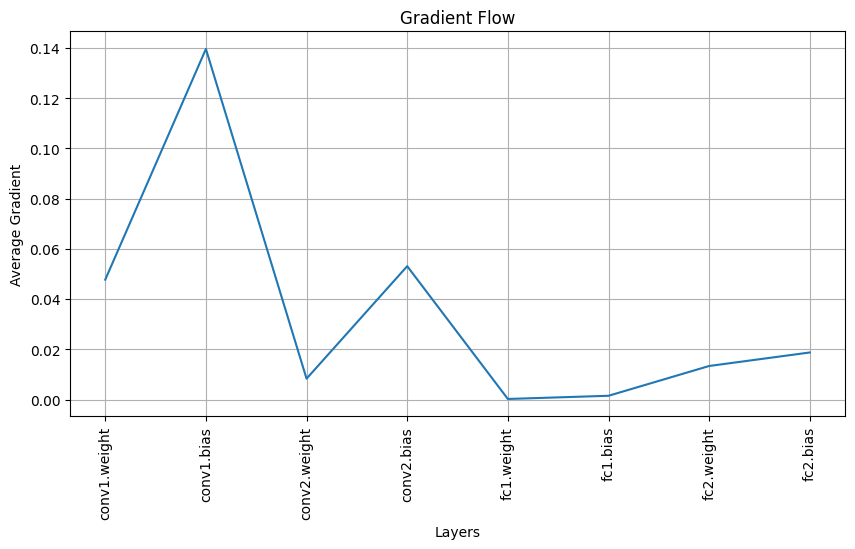

Epoch [3/25]  Loss: 436.8325  Acc: 59.93%


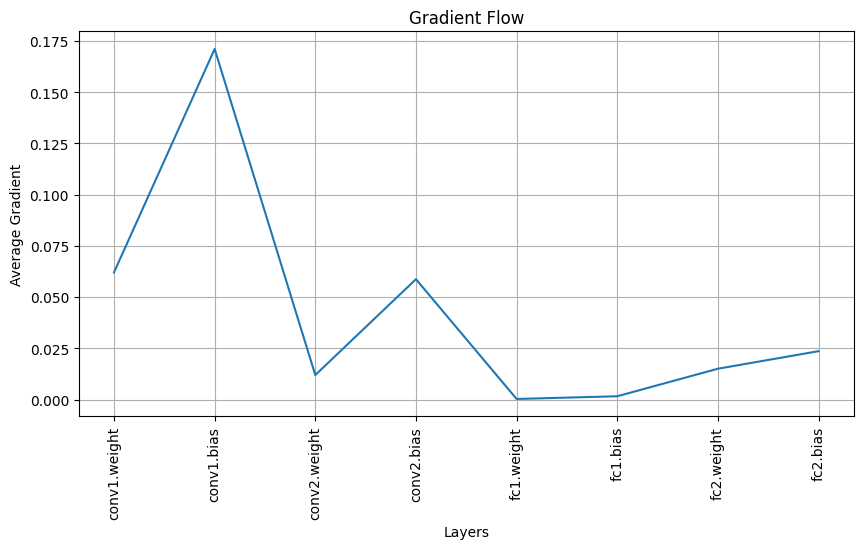

Epoch [4/25]  Loss: 403.8023  Acc: 63.59%


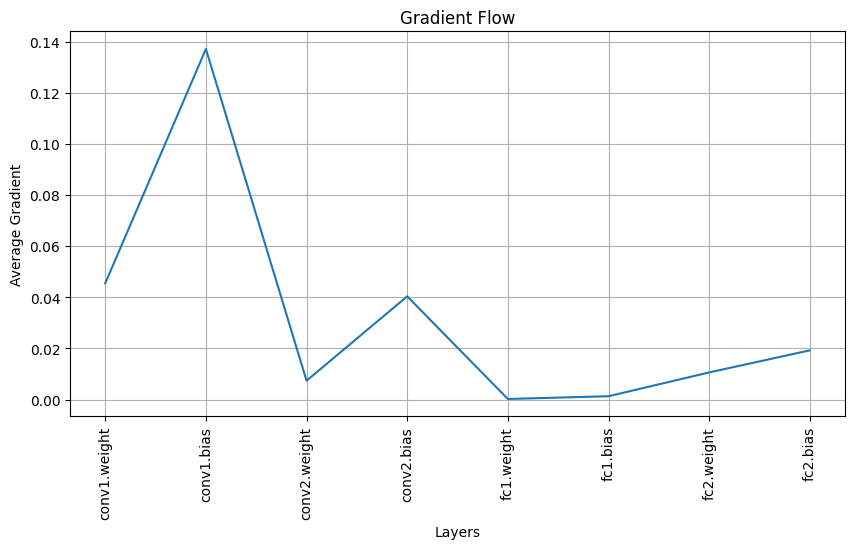

Epoch [5/25]  Loss: 379.1066  Acc: 65.48%


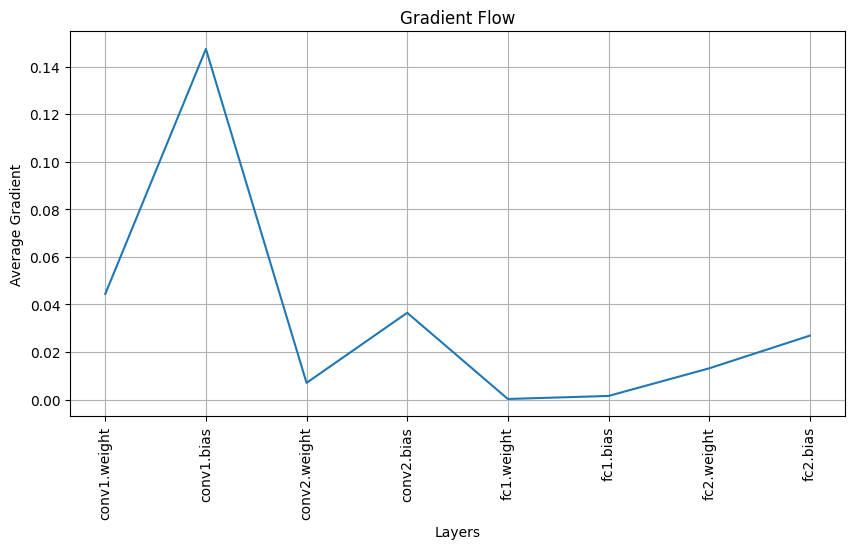

Epoch [6/25]  Loss: 359.5689  Acc: 67.38%


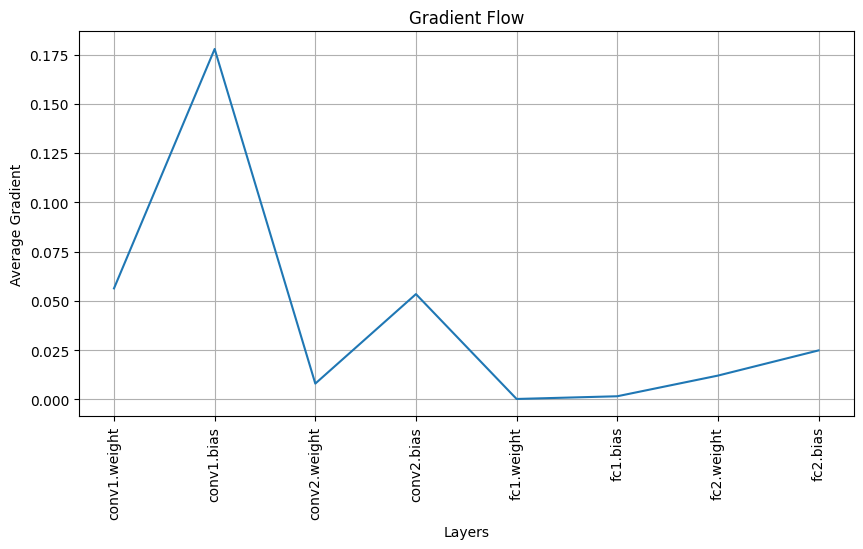

Epoch [7/25]  Loss: 345.7832  Acc: 68.60%


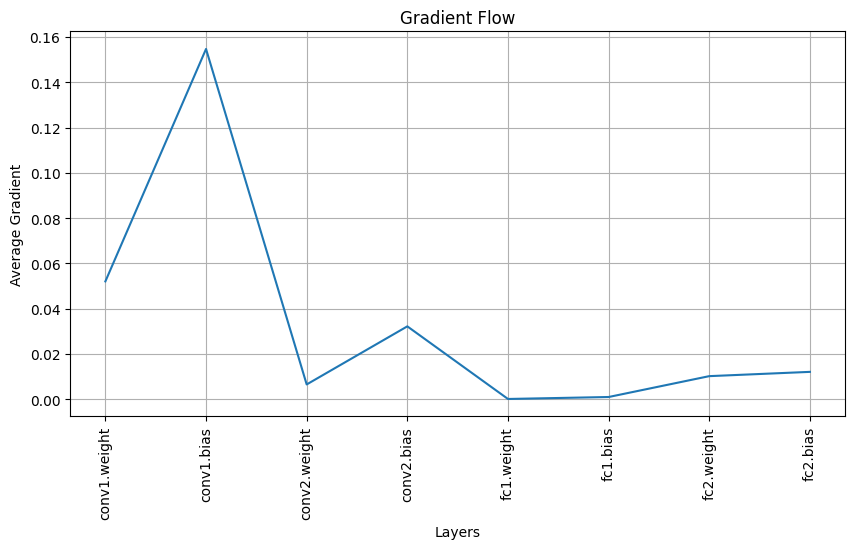

Epoch [8/25]  Loss: 332.0050  Acc: 70.16%


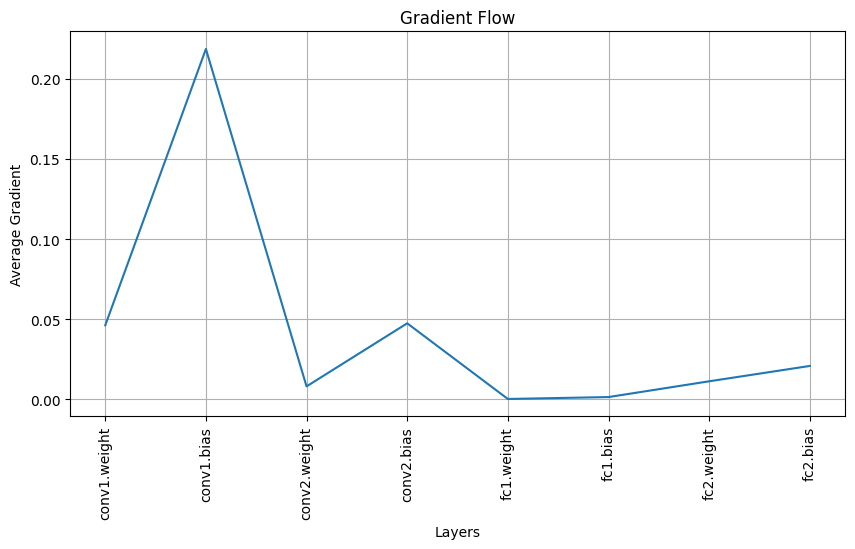

Epoch [9/25]  Loss: 321.7286  Acc: 71.13%


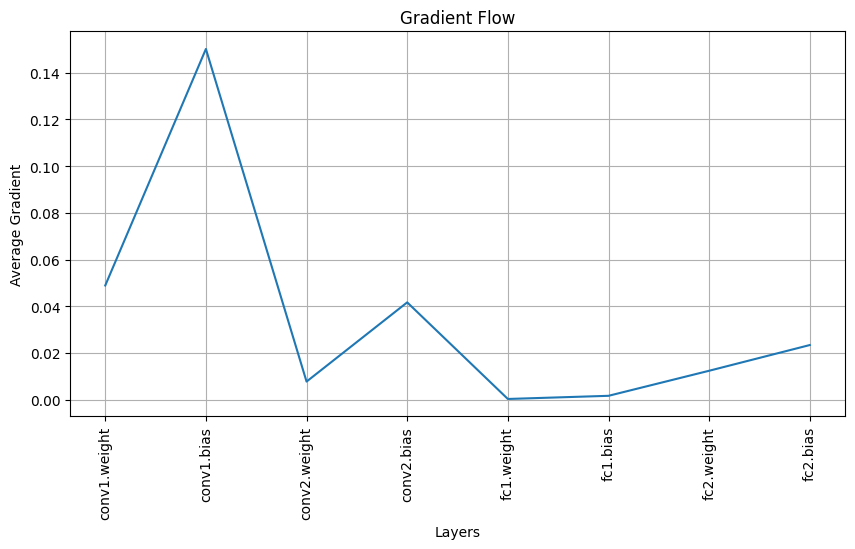

Epoch [10/25]  Loss: 310.5147  Acc: 72.09%


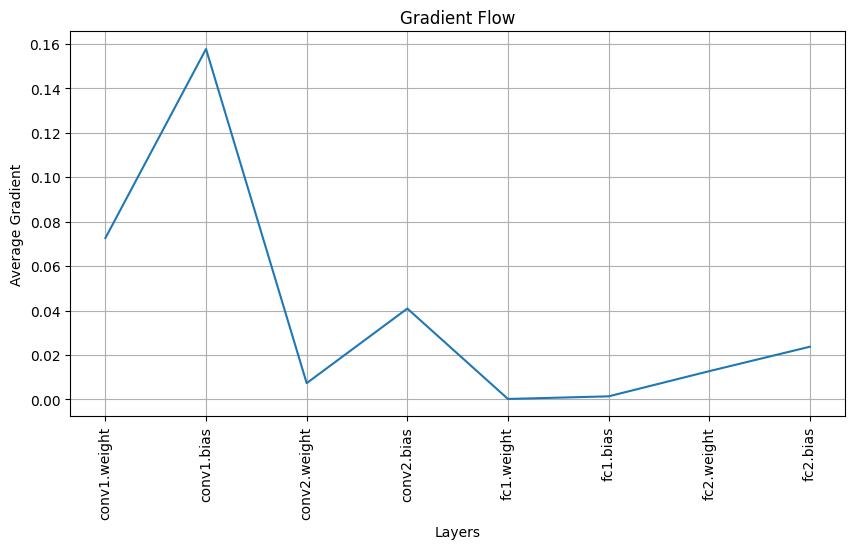

Epoch [11/25]  Loss: 302.9040  Acc: 72.56%


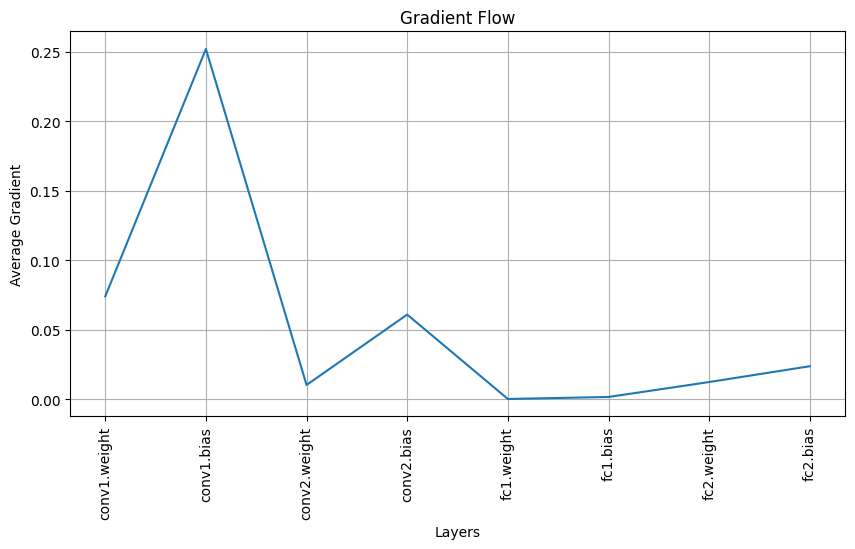

Epoch [12/25]  Loss: 293.6671  Acc: 73.51%


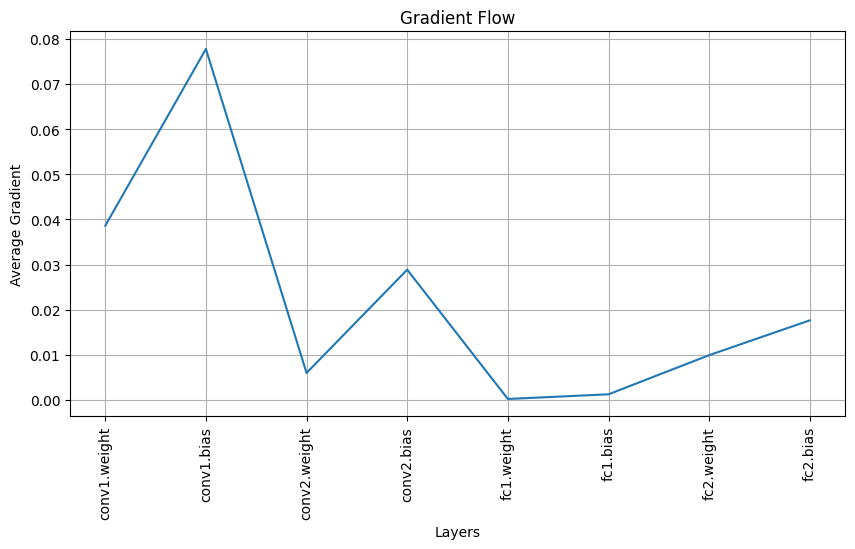

Epoch [13/25]  Loss: 284.7368  Acc: 74.51%


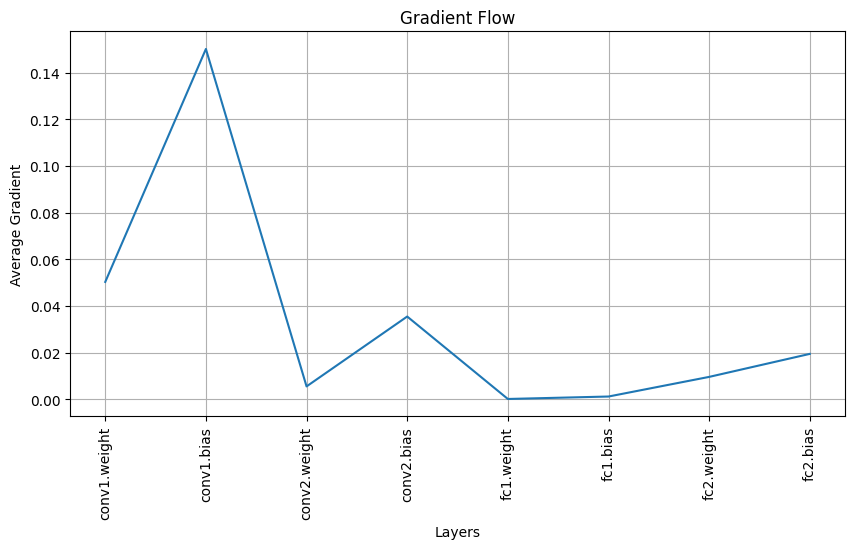

Epoch [14/25]  Loss: 280.7345  Acc: 74.78%


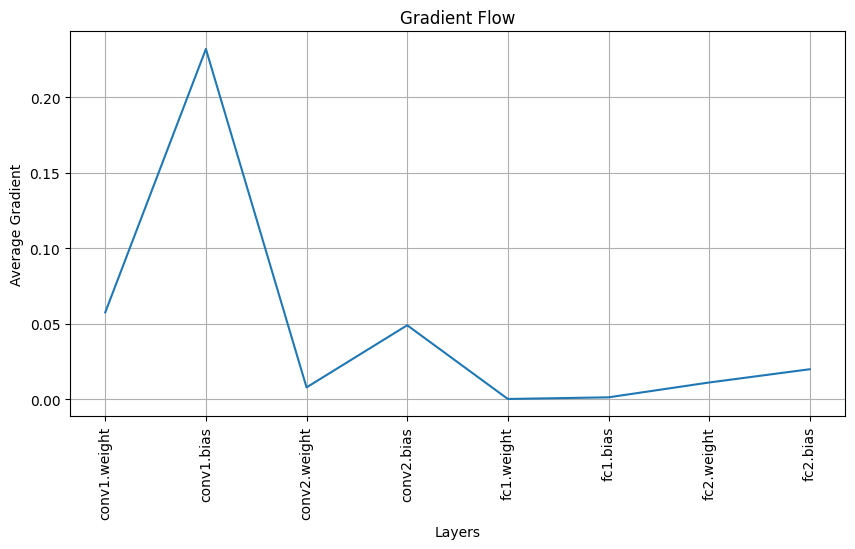

Epoch [15/25]  Loss: 274.2198  Acc: 75.41%


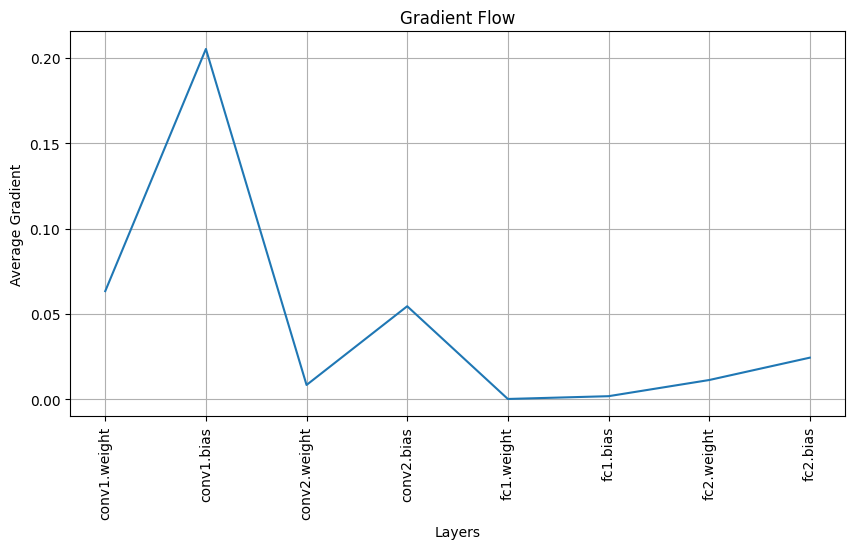

Epoch [16/25]  Loss: 268.0536  Acc: 75.82%


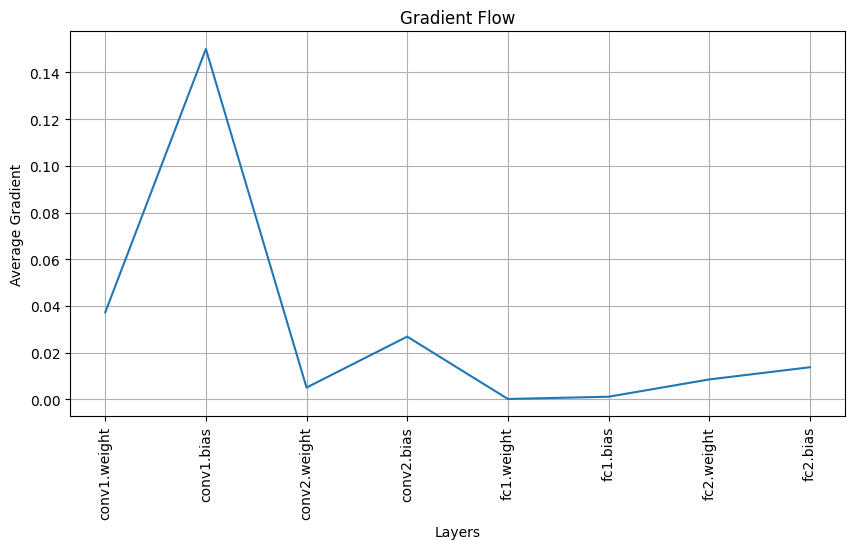

Epoch [17/25]  Loss: 264.2468  Acc: 76.42%


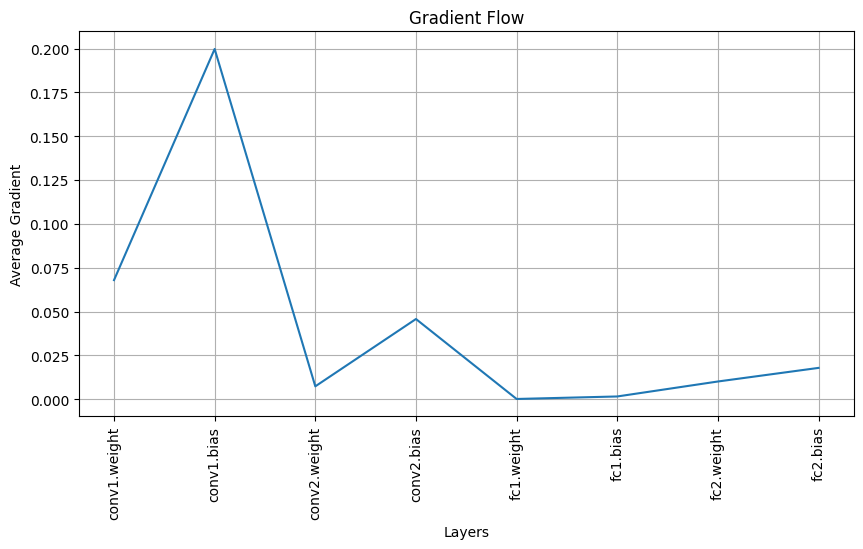

Epoch [18/25]  Loss: 259.3687  Acc: 76.52%


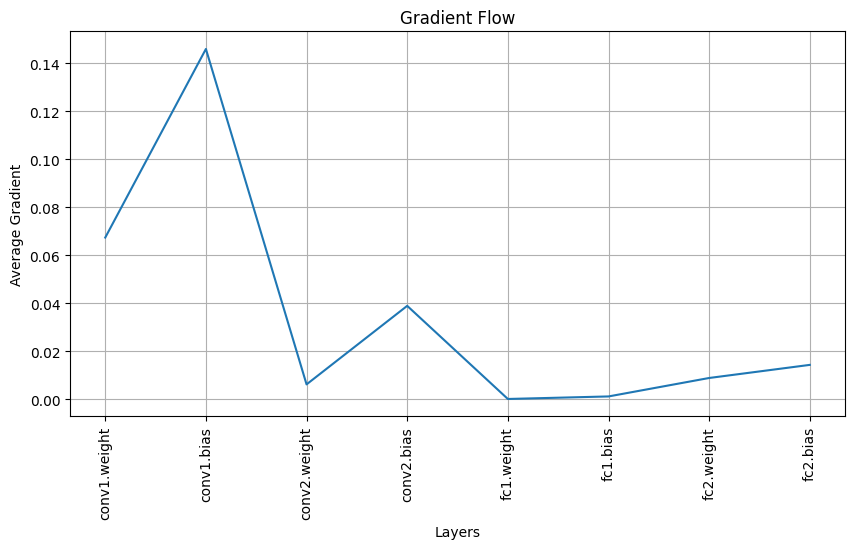

Epoch [19/25]  Loss: 254.8741  Acc: 77.13%


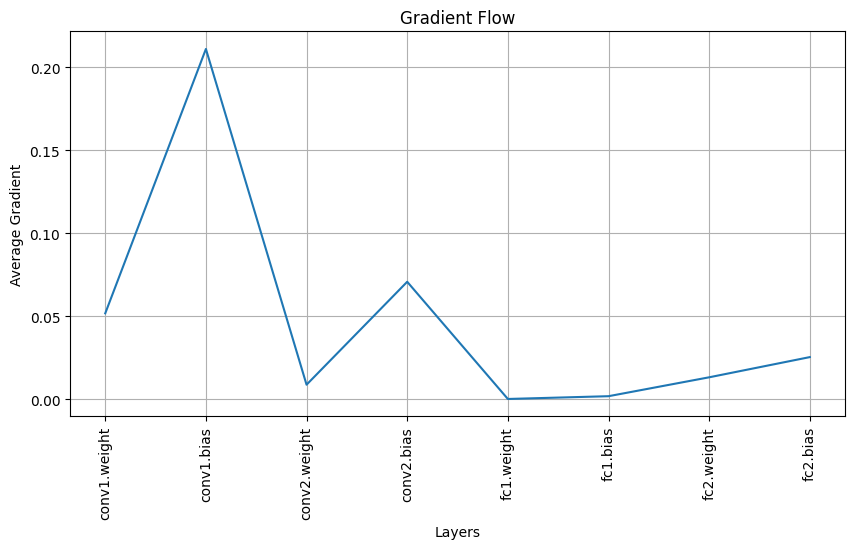

Epoch [20/25]  Loss: 252.0221  Acc: 77.40%


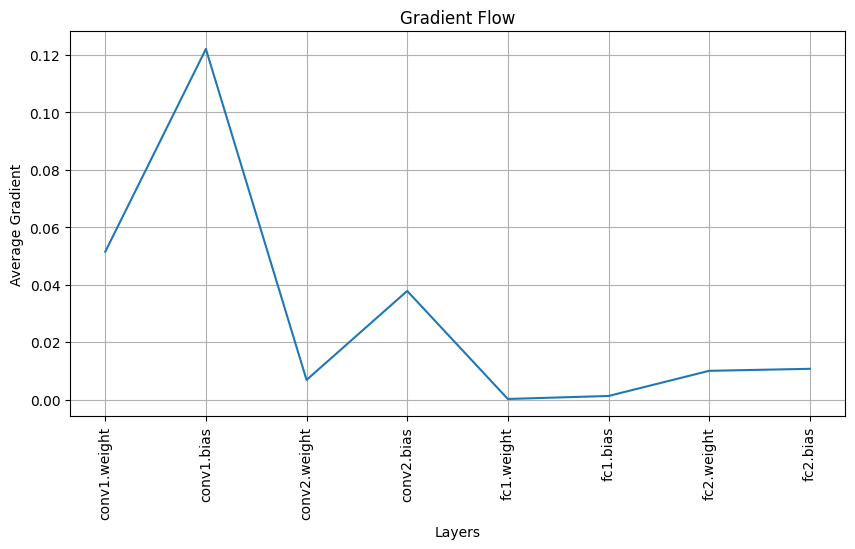

Epoch [21/25]  Loss: 246.0597  Acc: 78.10%


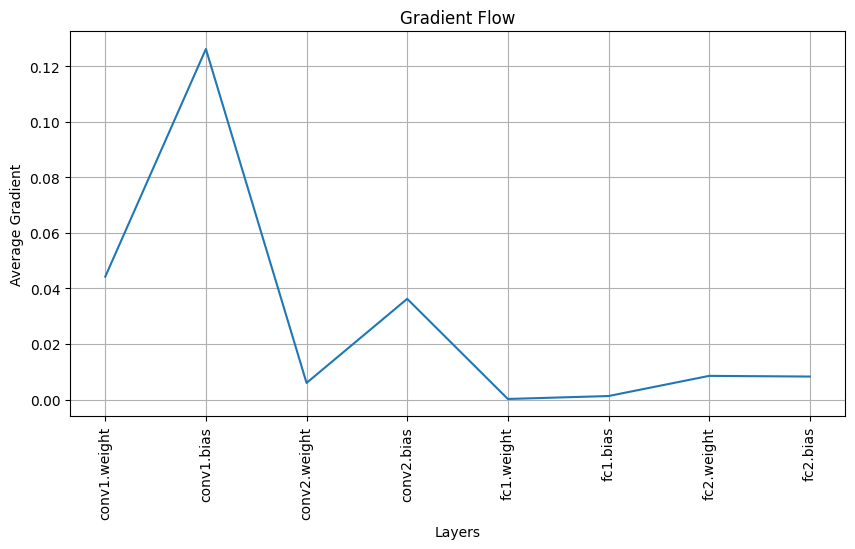

Epoch [22/25]  Loss: 244.0445  Acc: 78.20%


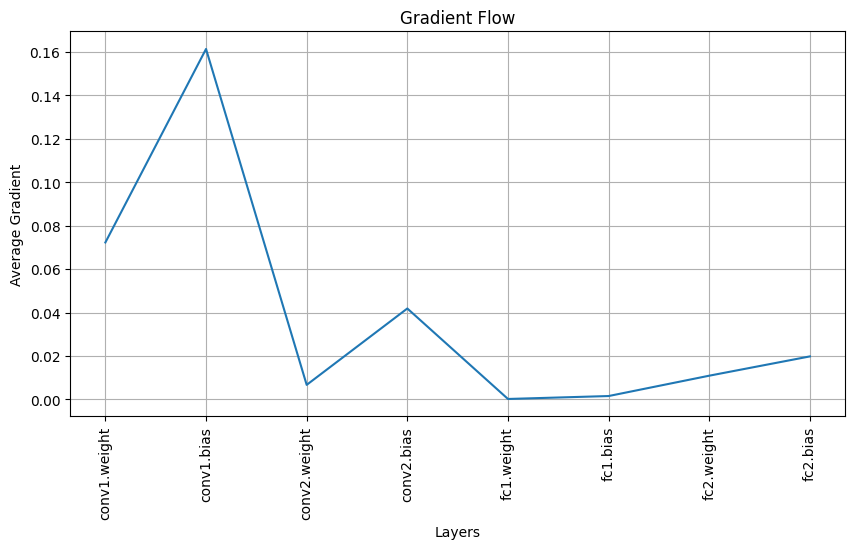

Epoch [23/25]  Loss: 238.7603  Acc: 78.51%


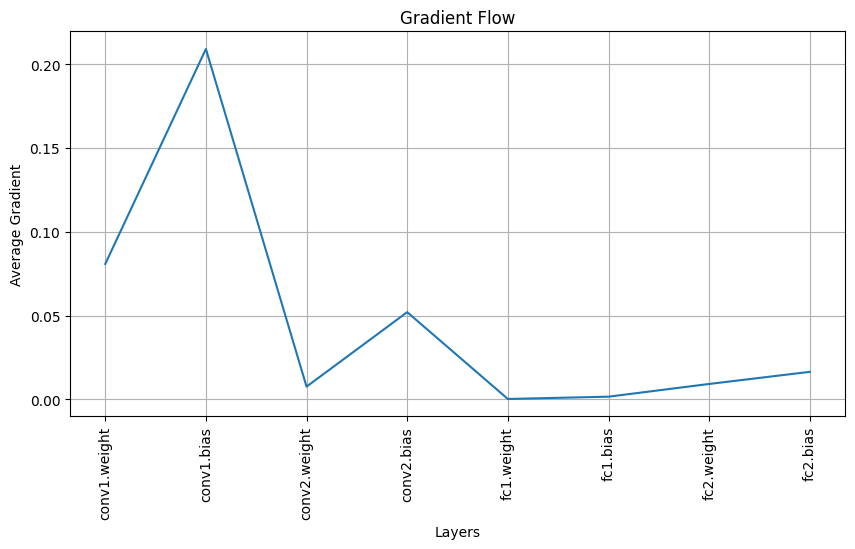

Epoch [24/25]  Loss: 234.9803  Acc: 78.95%


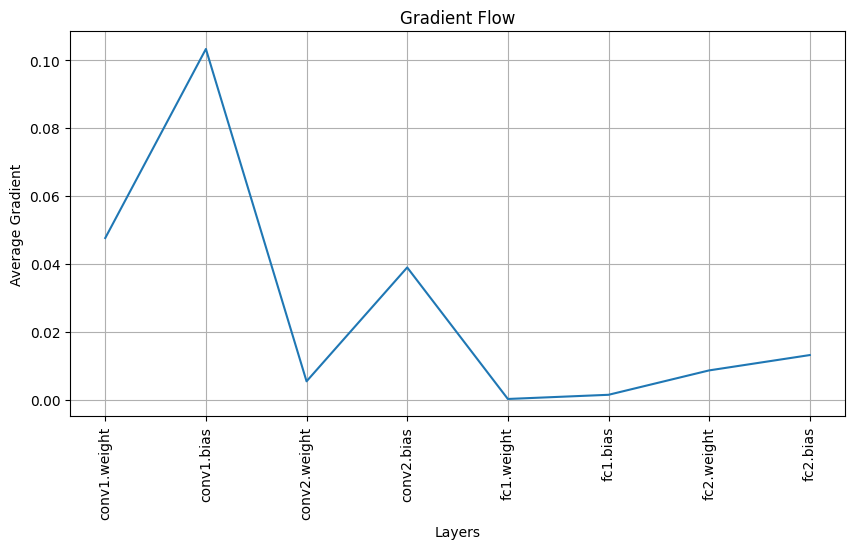

Epoch [25/25]  Loss: 233.5623  Acc: 79.16%


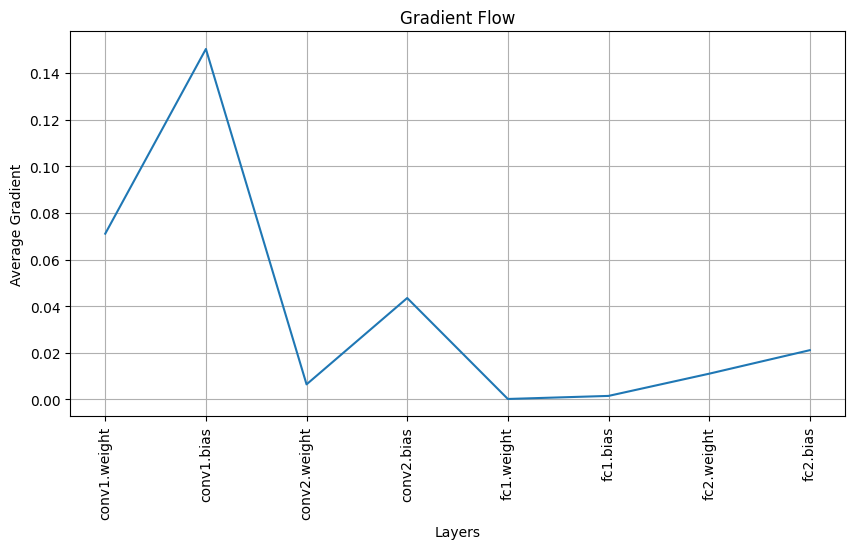

In [15]:
epochs = 25

for epoch in range(epochs):
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total

    print(f"Epoch [{epoch+1}/25]  Loss: {running_loss:.4f}  Acc: {acc:.2f}%")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": running_loss,
        "train_accuracy": acc
    })

    plot_gradient_flow(model.named_parameters())


In [16]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print("Test Accuracy:", test_accuracy)

wandb.log({"test_accuracy": test_accuracy})


Test Accuracy: 78.07


In [17]:
wandb.finish()


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test_accuracy,▁
train_accuracy,▁▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,25
test_accuracy,78.07
train_accuracy,79.158
train_loss,233.56229
